##Importing important libraries

In [1]:
#Basics
import numpy as np
import pandas as pd

#Utility
import urllib
import os
import shutil
import time
from PIL import Image

#Vizualization
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import cv2

#MODEL
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout, AveragePooling2D, Concatenate
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import MobileNetV2
from keras.optimizers import Adam

##uploading json file

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Indian_Number_plates.json to Indian_Number_plates.json


##Reading Json file

In [3]:
import pandas as pd
df = pd.read_json('Indian_Number_plates.json', lines = True)

In [4]:
df.head()

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


In [5]:
#Checking out annotation structure
df['annotation'][1]

[{'imageHeight': 449,
  'imageWidth': 494,
  'label': ['number_plate'],
  'notes': '',
  'points': [{'x': 0.16194331983805602, 'y': 0.850779510022271},
   {'x': 0.582995951417004, 'y': 1}]}]

In [6]:
os.mkdir("IndianPlates")

In [7]:
#Dictionray For Import
dataset = dict()
dataset["image_name"] = list()
dataset["image_width"] = list()
dataset["image_height"] = list()
dataset["top_x"] = list()
dataset["top_y"] = list()
dataset["bottom_x"] = list()
dataset["bottom_y"] = list()

In [8]:
#Extracting the Image and popualting the Dataset Dictionary
counter = 0
for index, row in df.iterrows():
    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert('RGB')
    img.save(f"IndianPlates/licensed_car{counter}.jpeg","JPEG")

    dataset["image_name"].append(f"licensed_car{counter}.jpeg")
    
    data = row["annotation"]
    
    dataset["image_width"].append(data[0]["imageWidth"])
    dataset["image_height"].append(data[0]["imageHeight"])
    dataset["top_x"].append(data[0]["points"][0]["x"])
    dataset["top_y"].append(data[0]["points"][0]["y"])
    dataset["bottom_x"].append(data[0]["points"][1]["x"])
    dataset["bottom_y"].append(data[0]["points"][1]["y"])
    
    counter += 1
print(f"Downloaded {counter} car images.")

Downloaded 237 car images.


In [9]:
#Saved For Future Use
pd.DataFrame(dataset).to_csv("indian_plates.csv", index=False)

In [11]:
WIDTH = 224
HEIGHT = 224

def display_car_image(index, scale=True, WIDTH=224, HEIGHT=224):
    images_dir = 'IndianPlates/'
    
    img = cv2.imread(images_dir + df['image_name'].iloc[index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, dsize=(WIDTH, HEIGHT))

    top_x = int(df['top_x'].iloc[index] * WIDTH)
    top_y = int(df['top_y'].iloc[index] * HEIGHT)
    bottom_x = int(df['bottom_x'].iloc[index] * WIDTH)
    bottom_y = int(df['bottom_y'].iloc[index] * HEIGHT)
    center_x = 20
    center_y = 20
     # adding bounding box to the number plate in the car
    bbox_width = 1
    bbox_color = (255, 0, 0)
    car = cv2.rectangle(img, (top_x, top_y), (bottom_x, bottom_y), bbox_color, bbox_width)
    car = cv2.circle(car, (center_x, center_x), radius=0, color=(0, 0, 255), thickness=-1)

    plt.figure(figsize=(20, 10))
    plt.imshow(car)
    plt.show()

    # cropping the number plate to display
    number_plate = Image.fromarray(img).crop((top_x + bbox_width, top_y + bbox_width, bottom_x, bottom_y))
    plt.figure(figsize=(5, 5))
    plt.imshow(number_plate)
    plt.show()

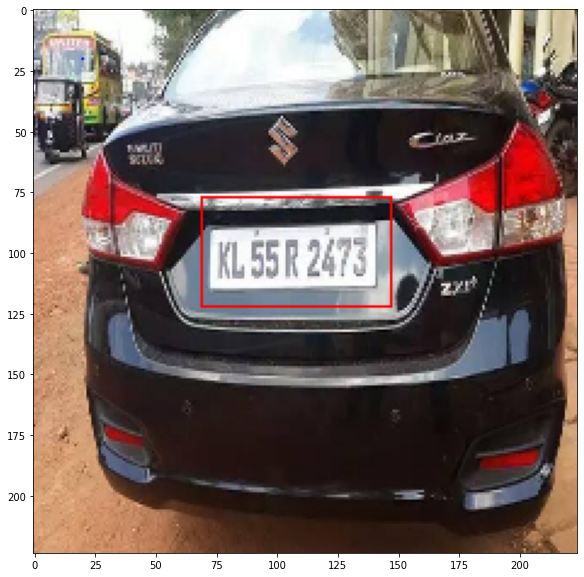

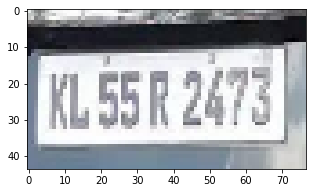

In [12]:
display_car_image(10)

In [13]:
def plot_loss_acc(acc,val_acc,loss,val_loss):

    epochs=range(len(acc)) # Get number of epochs

    #------------------------------------------------
    # Plot training and validation accuracy per epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'r')
    plt.plot(epochs, val_acc, 'b')
    plt.title('Training and validation accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid()
    plt.figure()
    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and validation loss')
    plt.legend(['Train', 'Validation'], loc='lower left')
    plt.grid()

In [14]:
from keras.preprocessing.image import ImageDataGenerator

In [15]:
#Creating Training and Validation Data Generators
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.1,
                            )

train_generator = datagen.flow_from_dataframe(
    df,
    directory="IndianPlates/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="training")


validation_generator = datagen.flow_from_dataframe(
    df,
    directory="IndianPlates/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="validation")

Found 214 validated image filenames.
Found 23 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.6/logging/__init__.py", line 994, in emit
    msg = self.format(record)
  File "/usr/lib/python3.6/logging/__init__.py", line 840, in format
    return fmt.format(record)
  File "/usr/lib/python3.6/logging/__init__.py", line 577, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.6/logging/__init__.py", line 338, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/usr/local/lib/python

In [16]:
#Estimating Step size for train and validation set
STEP_SIZE_TRAIN = int(np.ceil(train_generator.n / train_generator.batch_size))
STEP_SIZE_VAL = int(np.ceil(validation_generator.n / validation_generator.batch_size))

print("Train step size:", STEP_SIZE_TRAIN)
print("Validation step size:", STEP_SIZE_VAL)

train_generator.reset()
validation_generator.reset()


Train step size: 7
Validation step size: 1


##Defining the CNNModel

In [17]:
#Creating CNN
cnnmodel = Sequential()

cnnmodel.add(Conv2D(64, (3,3), activation='relu', input_shape=(WIDTH,HEIGHT,3)))
cnnmodel.add(MaxPooling2D(2,2))
cnnmodel.add(Conv2D(32, (3,3), activation='relu'))
cnnmodel.add(MaxPooling2D(2,2))
cnnmodel.add(Conv2D(16, (3,3), activation='relu'))
cnnmodel.add(MaxPooling2D(2,2))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(128, activation="relu"))
cnnmodel.add(Dense(64, activation="relu"))
cnnmodel.add(Dense(64, activation="relu"))
cnnmodel.add(Dense(4, activation="sigmoid"))

cnnmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0

In [18]:
cnnmodel.compile(optimizer=Adam(lr=0.0005), loss="mse", metrics=['acc'])

In [19]:
history = cnnmodel.fit_generator(train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VAL,
    epochs=30)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
7/7 [==============================] - 17s 2s/step - loss: 0.0368 - acc: 0.4533 - val_loss: 0.0264 - val_acc: 0.5217
Epoch 2/30
7/7 [==============================] - 17s 2s/step - loss: 0.0255 - acc: 0.5514 - val_loss: 0.0293 - val_acc: 0.4348
Epoch 3/30
7/7 [==============================] - 17s 2s/step - loss: 0.0235 - acc: 0.6262 - val_loss: 0.0249 - val_acc: 0.4348
Epoch 4/30
7/7 [==============================] - 17s 2s/step - loss: 0.0226 - acc: 0.6215 - val_loss: 0.0238 - val_acc: 0.5217
Epoch 5/30
7/7 [==============================] - 17s 2s/step - loss: 0.0208 - acc: 0.6589 - val_loss: 0.0233 - val_acc: 0.5652
Epoch 6/30
7/7 [==============================] - 18s 3s/step - loss: 0.0190 - acc: 0.7196 - val_loss: 0.0238 - val_acc: 0.6087
Epoch 7/30
7/7 [==============================] - 17s 2s/step - loss: 0.0157 - acc: 0.7804 - val_loss: 0.0203 - val_acc: 0.5217
Epoch 8/30
7/7 [============

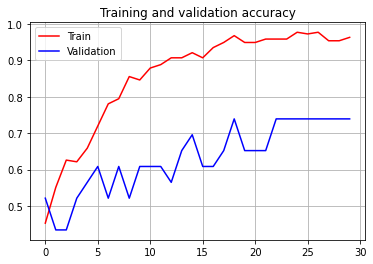

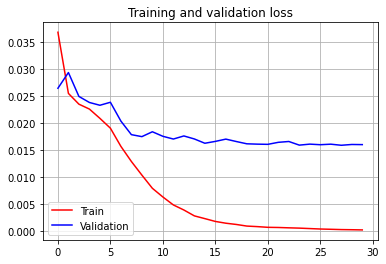

In [20]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

plot_loss_acc(acc,val_acc,loss,val_loss)